In [30]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [31]:
%%R

#install.packages("tibble")
#install.packages("dplyr")
#install.packages(ggplot2)
#install.packages("caret")
#install.packages("glmnet")

library(tibble)
library(dplyr)
library(ggplot2)
library(caret)
library(pROC)
library(ROSE)
library(glmnet)

In [32]:
%%R

binary_driving_mode <- function (df_chassis) {
    result <- ifelse(df_chassis$drivingMode == "COMPLETE_AUTO_DRIVE", 1, 0)

    return(result)
}


merge_chassis_pose <- function (df_chassis, df_pose) {
    
    
    df_chassis <- df_chassis[order(df_chassis$time), ]
    df_pose <- df_pose[order(df_pose$time), ]
    
    #make sure data is sorted by time fist

    chassis_time_arr <- df_chassis$time
    pose_time_arr <- df_pose$time

    matched_vector <- c()

    for (chassis_time in chassis_time_arr) {
        abs_time_diff_arr <- abs(pose_time_arr - chassis_time)

        min_index <-  which(abs_time_diff_arr == min(abs_time_diff_arr))
        
        matched_vector <-  c(matched_vector, pose_time_arr[min_index])
    }



    #df_chassis$matched <- df_pose$time[which(abs(pose_time_arr - df_chassis$time) == min(abs(pose_time_arr - df_chassis$time)))]
    df_chassis$matched <-  matched_vector
    df_pose$matched <-  df_pose$time


    return (list(df_chassis = df_chassis, df_pose = df_pose))


}

latlongStdDev <- function(df_pose){
    x <- df_pose["latitudeStdDev"]
    y <- df_pose["longitudeStdDev"]
    r <- sqrt(x^2 + y^2)

    return(r)

}

In [33]:
%%R
# Defining GMIDs for Red Routes
# Am creating a list of GMIDs for processing
red_route_gmIDs  <- c(
     '61b12e7a-f234-11ee-bb33-fb353e7798cd',
'fcc6fcd2-f013-11ee-b966-fb353e7798cd',
'05c7c824-cab8-11ee-aa4d-1d66adf2f0c7',
'211bdb36-f0da-11ee-ba1b-fb353e7798cd',
'868de15e-f3b3-11ee-bb4e-fb353e7798cd',
'72a03d4a-efe9-11ee-b966-fb353e7798cd',
'7fb7b9c0-c881-11ee-a7fc-dd032dba19e8',
'96f7a614-f549-11ee-8afa-cb629b0d53e6',
'1bbbfbae-c839-11ee-a7fc-dd032dba19e8',
'622bd2e8-f0e4-11ee-ba1f-fb353e7798cd',
'9798fe24-f143-11ee-ba78-fb353e7798cd',
'88dd6fbe-f224-11ee-bb21-fb353e7798cd',
'c9c6856c-d33c-11ee-b437-336917683bb8',
'd12cd1c4-caec-11ee-909c-e1dc60cf66f9',
'817d6848-efb6-11ee-b966-fb353e7798cd',
'1b6aca0e-efdf-11ee-b966-fb353e7798cd',
'41b67a28-f52f-11ee-8afa-cb629b0d53e6',
'fc211bb2-efca-11ee-b966-fb353e7798cd',
'84d96f18-f214-11ee-bb13-fb353e7798cd',
'fe973c9c-f53c-11ee-8afa-cb629b0d53e6',
'3151e9e2-eff3-11ee-b966-fb353e7798cd',
'c0555ef0-f50f-11ee-8afa-cb629b0d53e6',
'f711e68e-f0e1-11ee-ba1f-fb353e7798cd',
'c338788a-d324-11ee-b437-336917683bb8',
'd21965e6-f0fa-11ee-ba37-fb353e7798cd',
'88a68dd8-eef9-11ee-9385-ef789ffde1d3',
'f41cbd44-eff8-11ee-b966-fb353e7798cd',
'43a1a35e-f362-11ee-bb4e-fb353e7798cd',
'6d2ea45a-c839-11ee-a7fc-dd032dba19e8',
'01e65360-efd4-11ee-b966-fb353e7798cd',
'7cbd932e-f244-11ee-bb3f-fb353e7798cd',
'65cfbfd6-f396-11ee-bb4e-fb353e7798cd',
'94c53148-eeed-11ee-9385-ef789ffde1d3',
'fd1ab258-efa7-11ee-b966-fb353e7798cd',
'e7b934a8-ef1a-11ee-9385-ef789ffde1d3',
'de933de8-f112-11ee-ba4d-fb353e7798cd',
'd3698592-ef9d-11ee-b966-fb353e7798cd',
'dd72fdec-f0cf-11ee-ba0d-fb353e7798cd',
'b82476fe-f1f3-11ee-baff-fb353e7798cd',
'f755cf60-f132-11ee-ba6d-fb353e7798cd',
'853ef120-cad3-11ee-909c-e1dc60cf66f9',
'f0eebb6a-f0dc-11ee-ba1e-fb353e7798cd',
'cf831f42-f353-11ee-bb4e-fb353e7798cd',
'ecebb942-f162-11ee-ba97-fb353e7798cd',
'219f7eb8-ef87-11ee-b966-fb353e7798cd',
'd24820c8-f197-11ee-babe-fb353e7798cd',
'3d2d29ec-ef95-11ee-b966-fb353e7798cd',
'457dc5ee-f02a-11ee-b966-fb353e7798cd',
'2462c9d0-eecd-11ee-9385-ef789ffde1d3',
'51ef6da6-ca9f-11ee-909c-e1dc60cf66f9',
'c25271be-f3a4-11ee-bb4e-fb353e7798cd',
'8347b862-efad-11ee-b966-fb353e7798cd',
'8dbbbf1c-f0ef-11ee-ba29-fb353e7798cd',
'9189a2a8-f121-11ee-ba5b-fb353e7798cd',
'8fa6fe80-c869-11ee-a7fc-dd032dba19e8',
'5a4bccf4-effe-11ee-b966-fb353e7798cd'
)

In [34]:
%%R

df_merged <- tibble() # Ensure it's an empty tibble

for (id in red_route_gmIDs) {
    print(paste("Processing GMID:", id))
    
    temp_chassis_path <- sprintf("/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_canbus_chassis/%s_apollo_canbus_chassis.csv", id, id)
    temp_pose_path <- sprintf("/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_sensor_gnss_best_pose/%s_apollo_sensor_gnss_best_pose.csv", id, id)

    if (file.exists(temp_chassis_path) && file.exists(temp_pose_path)) {
        temp_chassis <- as_tibble(read.csv(temp_chassis_path))
        temp_pose <- as_tibble(read.csv(temp_pose_path))

        r <- latlongStdDev(temp_pose)
        temp_pose$latlongStdDev <- r

        results <- merge_chassis_pose(temp_chassis, temp_pose)
        result_full <- full_join(results$df_chassis, results$df_pose, by = "matched")

        result_full$binaryDrivingMode <- binary_driving_mode(result_full)
        df_merged <- bind_rows(df_merged, result_full)
    } else {
        warning(sprintf("Files not found for GMID: %s", id))
    }
}
print("Done loading data")

[1] "Processing GMID: 61b12e7a-f234-11ee-bb33-fb353e7798cd"
[1] "Processing GMID: fcc6fcd2-f013-11ee-b966-fb353e7798cd"
[1] "Processing GMID: 05c7c824-cab8-11ee-aa4d-1d66adf2f0c7"
[1] "Processing GMID: 211bdb36-f0da-11ee-ba1b-fb353e7798cd"
[1] "Processing GMID: 868de15e-f3b3-11ee-bb4e-fb353e7798cd"
[1] "Processing GMID: 72a03d4a-efe9-11ee-b966-fb353e7798cd"
[1] "Processing GMID: 7fb7b9c0-c881-11ee-a7fc-dd032dba19e8"
[1] "Processing GMID: 96f7a614-f549-11ee-8afa-cb629b0d53e6"
[1] "Processing GMID: 1bbbfbae-c839-11ee-a7fc-dd032dba19e8"
[1] "Processing GMID: 622bd2e8-f0e4-11ee-ba1f-fb353e7798cd"
[1] "Processing GMID: 9798fe24-f143-11ee-ba78-fb353e7798cd"
[1] "Processing GMID: 88dd6fbe-f224-11ee-bb21-fb353e7798cd"
[1] "Processing GMID: c9c6856c-d33c-11ee-b437-336917683bb8"
[1] "Processing GMID: d12cd1c4-caec-11ee-909c-e1dc60cf66f9"
[1] "Processing GMID: 817d6848-efb6-11ee-b966-fb353e7798cd"
[1] "Processing GMID: 1b6aca0e-efdf-11ee-b966-fb353e7798cd"
[1] "Processing GMID: 41b67a28-f52f-11ee

In [10]:
%%R
training_gmIDs <- red_route_gmIDs[red_route_gmIDs != "5a4bccf4-effe-11ee-b966-fb353e7798cd"]
testing_gmIDs <- "5a4bccf4-effe-11ee-b966-fb353e7798cd"

train_data <- df_merged %>% filter(groupMetadataID.x %in% training_gmIDs)
test_data <- df_merged %>% filter(groupMetadataID.x == testing_gmIDs)

print(paste("Training Data Rows:", nrow(train_data)))
print(paste("Testing Data Rows:", nrow(test_data)))

if (nrow(test_data) == 0) {
    stop("Error: Test data is empty. Check GMID filtering.")
}

[1] "Training Data Rows: 3001134"
[1] "Testing Data Rows: 54579"


In [13]:
%%R
train_data$latlongStdDev <- as.numeric(unlist(train_data$latlongStdDev))
str(train_data$latlongStdDev)  # Check the structure

In [16]:
%%R
model <- glm(
   binaryDrivingMode ~ speedMps + throttlePercentage + brakePercentage + steeringPercentage + latlongStdDev,
   data = train_data,
   family = binomial
)
summary(model)


Call:
glm(formula = binaryDrivingMode ~ speedMps + throttlePercentage + 
    brakePercentage + steeringPercentage + latlongStdDev, family = binomial, 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2500   0.6514   0.6974   0.7304   3.4205  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.8500473  0.0050512  168.28  < 2e-16 ***
speedMps            0.0204820  0.0002559   80.04  < 2e-16 ***
throttlePercentage  0.0020149  0.0001203   16.75  < 2e-16 ***
brakePercentage     0.0009052  0.0001596    5.67 1.42e-08 ***
steeringPercentage  0.0145121  0.0001556   93.26  < 2e-16 ***
latlongStdDev      -0.0564894  0.0007851  -71.95  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3246295  on 3001133  degrees of freedom
Residual deviance: 3212697  on 3001128  degrees of freedom
AIC: 3212709

Numb

In [18]:
%%R
test_data$latlongStdDev <- as.numeric(unlist(test_data$latlongStdDev))

In [19]:
%%R
predictions <- predict(model, test_data, type = "response")
predicted_classes <- ifelse(predictions > 0.5, 1, 0)

accuracy <- mean(predicted_classes == test_data$binaryDrivingMode)
print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.837574891441763"


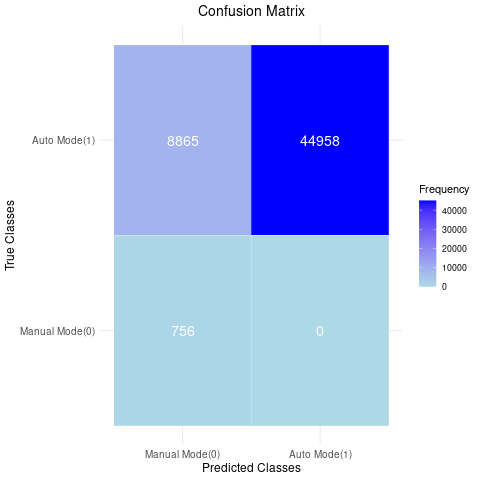

In [29]:
%%R
# Load required libraries
library(ggplot2)
library(caret)

# Map the values to labels (1 -> "Auto_mode", 0 -> "Manual")
predicted_classes_labeled <- factor(predicted_classes, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))
actual_classes_labeled <- factor (test_data$binaryDrivingMode, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))

# Generate the confusion matrix
cm <- confusionMatrix(predicted_classes_labeled, actual_classes_labeled)
cm_table <- as.data.frame(cm$table)

# Rename columns for better understanding
colnames(cm_table) <- c("Actual", "Predicted", "Frequency")

# Create the colored confusion matrix plot
ggplot(cm_table, aes(x = Predicted, y = Actual, fill = Frequency)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "lightblue", high = "blue", name = "Frequency") +
  geom_text(aes(label = Frequency), color = "white", size = 5) +
  labs(title = "Confusion Matrix", x = "Predicted Classes", y = "True Classes") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, size = 14),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

In [20]:
%%R

actual_manual_mode <- test_data[test_data$binaryDrivingMode == 0, ]
actual_latitudes <- actual_manual_mode$latitude
actual_longitudes <- actual_manual_mode$longitude

predicted_manual_mode <- test_data[predicted_classes == 0, ]
predicted_latitudes <- predicted_manual_mode$latitude
predicted_longitudes <- predicted_manual_mode$longitude

min_length <- min(length(actual_latitudes), length(predicted_latitudes))
actual_latitudes <- actual_latitudes[1:min_length]
actual_longitudes <- actual_longitudes[1:min_length]
predicted_latitudes <- predicted_latitudes[1:min_length]
predicted_longitudes <- predicted_longitudes[1:min_length]

manual_mode_comparison <- data.frame(
    actual_latitude = actual_latitudes,
    actual_longitude = actual_longitudes,
    predicted_latitude = predicted_latitudes,
    predicted_longitude = predicted_longitudes
)

print(head(manual_mode_comparison))

  actual_latitude actual_longitude predicted_latitude predicted_longitude
1        39.36454        -82.10306           39.36453           -82.10306
2        39.36454        -82.10306           39.36453           -82.10306
3        39.36454        -82.10306           39.36453           -82.10306
4        39.36454        -82.10306           39.36453           -82.10306
5        39.36454        -82.10306           39.36453           -82.10306
6        39.36454        -82.10306           39.36453           -82.10306


In [24]:
import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri
from rpy2.robjects import conversion

# Activate automatic pandas conversion
pandas2ri.activate()

# Fetch the R dataframe
manual_mode_comparison_r = robjects.globalenv["manual_mode_comparison"]

# Convert R DataFrame to Pandas
manual_mode_comparison_py = conversion.rpy2py(manual_mode_comparison_r)

# Rename for clarity
df = manual_mode_comparison_py

# Display first few rows
print(df.head())

   actual_latitude  actual_longitude  predicted_latitude  predicted_longitude
1         39.36454        -82.103062           39.364532           -82.103057
2         39.36454        -82.103062           39.364532           -82.103057
3         39.36454        -82.103062           39.364532           -82.103057
4         39.36454        -82.103062           39.364532           -82.103057
5         39.36454        -82.103062           39.364532           -82.103057


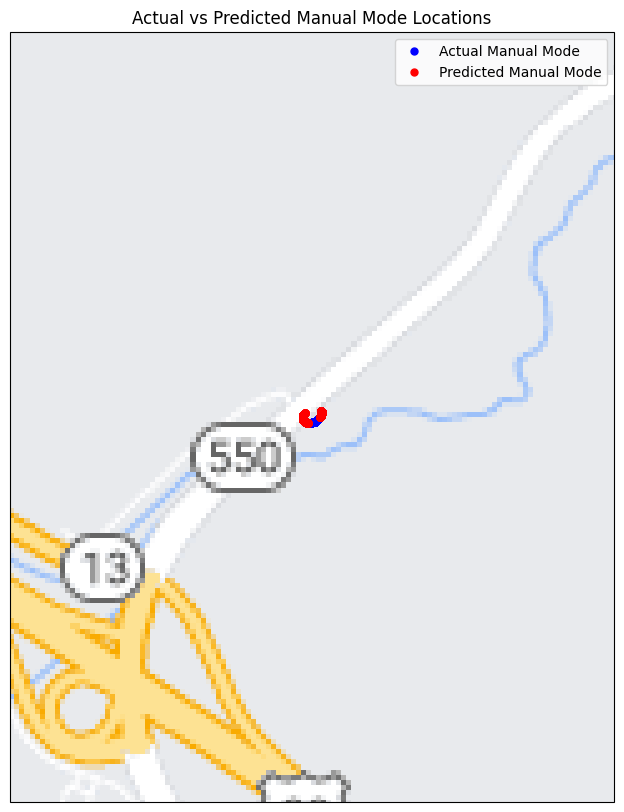

In [25]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

minLat, maxLat = df['actual_latitude'].min(), df['actual_latitude'].max()
minLon, maxLon = df['actual_longitude'].min(), df['actual_longitude'].max()

expansion_coeff = 0.005

street_map = GoogleTiles(style='street')

ax = plt.axes(projection=street_map.crs)
ax.set_extent(
    [minLon - expansion_coeff, maxLon + expansion_coeff, 
     minLat - expansion_coeff, maxLat + expansion_coeff], 
    ccrs.PlateCarree()
)

ax.add_image(street_map, 14)

true_manual_lat = df['actual_latitude']
true_manual_lon = df['actual_longitude']
pred_manual_lat = df['predicted_latitude']
pred_manual_lon = df['predicted_longitude']

plt.plot(true_manual_lon, true_manual_lat, 
         marker='o', ls='', color='blue', ms=5, 
         label='Actual Manual Mode', transform=ccrs.PlateCarree())

plt.plot(pred_manual_lon, pred_manual_lat, 
         marker='o', ls='', color='red', ms=5, 
         label='Predicted Manual Mode', transform=ccrs.PlateCarree())

plt.title('Actual vs Predicted Manual Mode Locations')
plt.legend()
plt.show()

In [28]:
print(df_test_gmid.head())  # Verify if latitude and longitude are present
print(df_test_gmid[['latitude', 'longitude']].describe())  # Check min/max values

NameError: name 'df_test_gmid' is not defined